In [46]:
pip install kmeans-constrained


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement kmeans-constrained
ERROR: No matching distribution found for kmeans-constrained


The optimized centroids are:  [[11.32167267 75.934743  ]
 [11.3155065  75.93174875]
 [11.3209165  75.93746967]
 [11.3187184  75.9320954 ]
 [11.3164505  75.9369395 ]]


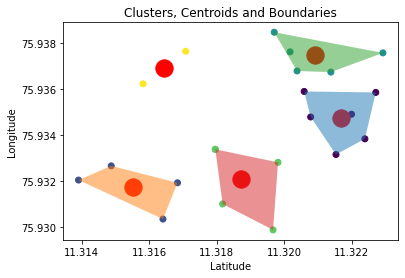

reference_point :  [array([11.321999, 75.93491 ]), array([11.3155065 , 75.93174875]), array([11.320914, 75.937614]), array([11.31982 , 75.932818]), array([11.3164505, 75.9369395])]


TypeError: 'numpy.ndarray' object is not callable

In [100]:
#final working model of truck-drone hybrid with truck-only points in degree
from k_means_constrained import KMeansConstrained

# Your data
data = np.array([[11.31982, 75.932818],
                [11.321539, 75.933159],
                [11.322396, 75.933841],
                [11.321999, 75.93491],
                [11.320788, 75.93479],
                [11.320595, 75.9359],
                [11.320384, 75.936791],
                [11.320177, 75.937621],
                [11.319707, 75.938474],
                [11.320914, 75.937614],
                [11.321387, 75.936741],
                [11.322719, 75.935858],
                [11.32293, 75.937577],
                [11.319673, 75.929881],
                [11.316408, 75.930353],
                [11.318177, 75.93101],
                [11.317961, 75.933384],
                [11.316839, 75.931929],
                [11.314874, 75.932665],
                [11.313905, 75.932048],
                [11.315818, 75.936233],
                [11.317083, 75.937646],
                [11.317961, 75.933384]
])

# Your predefined points
predefined_points = np.array([[11.31982, 75.932818], [11.320914, 75.937614],[11.321999, 75.93491]]) 

# Let's say the optimal number of clusters is 3
# and you want a maximum of 10 points in a cluster
kmeans = KMeansConstrained(n_clusters=5, size_max=6, init='k-means++', n_init=10, random_state=0)

# Fit the KMeans model to your data
kmeans.fit(data)

# The optimized centroids
optimized_points = kmeans.cluster_centers_

print("The optimized centroids are: ", optimized_points)

import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Assuming that 'kmeans' is your trained model and 'data' is your dataset

# Get the cluster assignments for each data point
labels = kmeans.labels_

# Plot the data points, color-coded by cluster
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')

# Plot the optimized centroids
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], s=300, c='red')

# Draw the boundaries
for i in range(kmeans.n_clusters):
    # Select the data points belonging to cluster i
    ds = data[np.where(labels==i)]
    # Compute the Convex Hull of the cluster points if there are at least 3 points
    if len(ds) >= 3:
        hull = ConvexHull(ds)
        # Get the points forming the hull
        hull_points = ds[hull.vertices]
        # Plot the hull
        plt.fill(hull_points[:,0], hull_points[:,1], alpha=0.5)

plt.title('Clusters, Centroids and Boundaries')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

import pandas as pd
from scipy.spatial.distance import cdist

# Initialize lists to hold the data
cluster_numbers = []
point_numbers = []
distances = []
reference_point_coordinates = []
point_coordinates = []

# Get the labels of the clusters for each data point
labels = kmeans.labels_
final_centroid = []

# For each cluster
for i in range(kmeans.n_clusters):
    # Get the points in the cluster
    cluster_points = data[np.where(labels==i)]
    # Get the centroid of the cluster
    centroid = kmeans.cluster_centers_[i]
    # Check if any of the predefined points are in the cluster
    predefined_point_in_cluster = None
    for point in predefined_points:
        if np.any(np.all(cluster_points == point, axis=1)):
            predefined_point_in_cluster = point
            break
    # If a predefined point is in the cluster, calculate the distance of each point in the cluster from the predefined point
    if predefined_point_in_cluster is not None:
        dists = cdist(cluster_points, predefined_point_in_cluster.reshape(1, -1))
        reference_point = predefined_point_in_cluster
        final_centroid.append(reference_point)
    else:
        # If no predefined point is in the cluster, calculate the distance of each point in the cluster from the centroid
        dists = cdist(cluster_points, centroid.reshape(1, -1))
        reference_point = centroid
        final_centroid.append(centroid)
    # Append the data to the lists
    for j in range(len(cluster_points)):
        cluster_numbers.append(i)
        point_numbers.append(j+1)
        distances.append(dists[j][0])
        reference_point_coordinates.append(reference_point)
        point_coordinates.append(cluster_points[j])
 # Calculate the distance matrix
print("reference_point : ",final_centroid)
dist_matrix = distance_matrix(final_centroid, final_centroids)

print("The distance matrix is: ")
print(dist_matrix)

# Prepare the data for the DataFrame
data = {
    'Cluster Number': cluster_numbers,
    'Point Number': point_numbers,
    'Reference Point Coordinates': reference_point_coordinates,
    'Point Coordinates': point_coordinates,
    'Distance': distances
}

# Create a DataFrame
df = pd.DataFrame(data)

# Write the DataFrame to a CSV file
df.to_csv('distances.csv', index=False)

print("CSV file created successfully!")
# Convert the distance matrix to a DataFrame
df = pd.DataFrame(dist_matrix)

# Set the column and row names to the coordinates of the centroids
df.columns = [str(centroid) for centroid in final_centroid]
df.index = [str(centroid) for centroid in final_centroid]

# Save the DataFrame to a CSV file
df.to_csv('distance_matrix.csv')

print("The distance matrix has been saved to 'distance_matrix.csv'.")




In [158]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import haversine_distances
from math import radians
def generate_random_data(num_points):
    # Generate weights between 1 and 3 kg for 85% of the points
    num_weights1 = int(0.85*num_points)
    weights1 = np.random.uniform(low=1, high=3, size=num_weights1)
    # Generate weights between 3 and 6 kg for the remaining points
    num_weights2 = num_points - num_weights1
    weights2 = np.random.uniform(low=3, high=6, size=num_weights2)
    # Concatenate the two arrays to get the final weights array
    weights = np.concatenate((weights1, weights2))

    latitudes = np.random.uniform(low=11.313905, high=11.32293, size=(num_points,))
    longitudes = np.random.uniform(low=75.929881, high=75.938474, size=(num_points,))
    return np.column_stack((latitudes, longitudes, weights))

# Generate 23 random data points
random_data = generate_random_data(30)

def separate_data(random_data):
    # Predefined points are those with weight > 4 kg
    predefined_points = random_data[random_data[:,2] > 4][:, :2]

    # Data points are just the latitude and longitude columns of all points
    data_points = random_data[:, :2]

    return predefined_points, data_points



Data Points:
[[11.32087295 75.93819097]
 [11.32024526 75.93325447]
 [11.31434069 75.93067787]
 [11.32150794 75.93485807]
 [11.32037825 75.93425774]
 [11.31845025 75.9356097 ]
 [11.3152466  75.93146618]
 [11.31678316 75.9372968 ]
 [11.31949085 75.93631518]
 [11.31527739 75.93205822]
 [11.31683195 75.93332958]
 [11.31814181 75.93134036]
 [11.31427119 75.93157524]
 [11.32036974 75.93021854]
 [11.31611719 75.93367872]
 [11.31523457 75.93472753]
 [11.31861047 75.93155825]
 [11.32137057 75.93784589]
 [11.31490979 75.93011177]
 [11.31829341 75.93006367]
 [11.31398339 75.93700731]
 [11.31618437 75.93800382]
 [11.31621554 75.93655233]
 [11.31431949 75.93148212]
 [11.31562934 75.93177645]
 [11.32013242 75.93028677]
 [11.31399365 75.93155183]
 [11.32134846 75.93586717]
 [11.32122569 75.93100339]
 [11.32286416 75.93370284]]
Predefined Points:
[[11.32134846 75.93586717]
 [11.32122569 75.93100339]]
The optimized centroids are:  [[11.31981283 75.93106418]
 [11.31620537 75.93281847]
 [11.31451357 75.

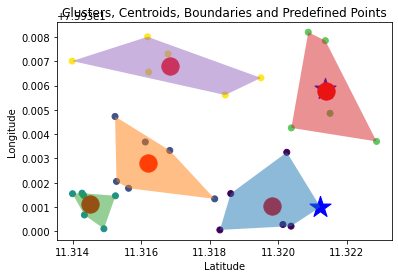

cluster:  [[11.32024526 75.93325447]
 [11.32036974 75.93021854]
 [11.31861047 75.93155825]
 [11.31829341 75.93006367]
 [11.32013242 75.93028677]
 [11.32122569 75.93100339]]
point:  [11.32134846 75.93586717]
point:  [11.32122569 75.93100339]
cluster:  [[11.31527739 75.93205822]
 [11.31683195 75.93332958]
 [11.31814181 75.93134036]
 [11.31611719 75.93367872]
 [11.31523457 75.93472753]
 [11.31562934 75.93177645]]
point:  [11.32134846 75.93586717]
point:  [11.32122569 75.93100339]
cluster:  [[11.31434069 75.93067787]
 [11.3152466  75.93146618]
 [11.31427119 75.93157524]
 [11.31490979 75.93011177]
 [11.31431949 75.93148212]
 [11.31399365 75.93155183]]
point:  [11.32134846 75.93586717]
point:  [11.32122569 75.93100339]
cluster:  [[11.32087295 75.93819097]
 [11.32150794 75.93485807]
 [11.32037825 75.93425774]
 [11.32137057 75.93784589]
 [11.32134846 75.93586717]
 [11.32286416 75.93370284]]
point:  [11.32134846 75.93586717]
point:  [11.32122569 75.93100339]
cluster:  [[11.31845025 75.9356097 ]

In [160]:
#final working model in km
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import haversine_distances
from math import radians

# Function to convert degrees to radians
def to_radians(degrees):
    return [radians(deg) for deg in degrees]



# Separate the random data into predefined points and data points
predefined_points, data = separate_data(random_data)
print("\nData Points:")
print(data)
print("Predefined Points:")
print(predefined_points)

from k_means_constrained import KMeansConstrained

from geopy.distance import geodesic

def calculate_distance_matrix_km(data):
    num_points = data.shape[0]
    dist_matrix = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            dist_matrix[i, j] = geodesic(data[i], data[j]).kilometers
    return dist_matrix

dist_matrix_km = calculate_distance_matrix_km(data)
np.savetxt("distance_matrix_truck.csv", dist_matrix_km, delimiter=",")

# Let's say the optimal number of clusters is 3
# and you want a maximum of 10 points in a cluster
kmeans = KMeansConstrained(n_clusters=5, size_max=6, init='k-means++', n_init=10, random_state=0)

# Fit the KMeans model to your data
kmeans.fit(data)

# The optimized centroids
optimized_points = kmeans.cluster_centers_

print("The optimized centroids are: ", optimized_points)

import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Assuming that 'kmeans' is your trained model and 'data' is your dataset

# Get the cluster assignments for each data point
labels = kmeans.labels_

# Plot the data points, color-coded by cluster
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')

# Plot the predefined points
plt.scatter(predefined_points[:, 0], predefined_points[:, 1], s=500, c='blue', marker='*')

# Plot the optimized centroids
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], s=300, c='red')

# Draw the boundaries
for i in range(kmeans.n_clusters):
    # Select the data points belonging to cluster i
    ds = data[np.where(labels==i)]
    # Compute the Convex Hull of the cluster points if there are at least 3 points
    if len(ds) >= 3:
        hull = ConvexHull(ds)
        # Get the points forming the hull
        hull_points = ds[hull.vertices]
        # Plot the hull
        plt.fill(hull_points[:,0], hull_points[:,1], alpha=0.5)

plt.title('Clusters, Centroids, Boundaries and Predefined Points')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

import pandas as pd
from scipy.spatial.distance import cdist

# Initialize lists to hold the data
cluster_numbers = []
point_numbers = []
distances = []
reference_point_coordinates = []
point_coordinates = []

# Get the labels of the clusters for each data point
labels = kmeans.labels_
final_centroid = []
# Add each predefined point to final_centroid
for point in predefined_points:
    final_centroid.append(point)


# For each cluster
for i in range(kmeans.n_clusters):
    # Get the points in the cluster
    cluster_points = data[np.where(labels==i)]
    print("cluster: ",cluster_points)
    # Get the centroid of the cluster
    centroid = kmeans.cluster_centers_[i]
    # Check if any of the predefined points are in the cluster
    predefined_points_in_cluster = []
    for point in predefined_points:
        print("point: ",point)
        if np.any(np.all(cluster_points == point, axis=1)):
            predefined_points_in_cluster.append(point)
    # If predefined points are in the cluster, use the first one as the reference point
    if predefined_points_in_cluster:
        reference_point = predefined_points_in_cluster[0]
    else:
        # If no predefined point is in the cluster, use the centroid as the reference point
        reference_point = centroid
        final_centroid.append(centroid)

    # Append the data to the lists
    for j in range(len(cluster_points)):
        cluster_numbers.append(i)
        point_numbers.append(j+1)
        reference_point_rad = to_radians(reference_point)  # Use reference_point here
        cluster_point_rad = to_radians(cluster_points[j])
        distance_matrix = haversine_distances([reference_point_rad], [cluster_point_rad])
        distance_km = distance_matrix[0][0] * 6371000 / 1000  # Convert meters to kilometers
        distances.append(distance_km)
        reference_point_coordinates.append(reference_point)  # Use reference_point here
        point_coordinates.append(cluster_points[j])



 # Calculate the distance matrix
print("final centroid : ",final_centroid)
dist_matrix = cdist(final_centroid, final_centroid)

print("The distance matrix is: ")
print(dist_matrix_km)
# Convert the distance matrix to kilometers
dist_matrix_km = dist_matrix * 111.32  # 1 degree of latitude ~= 111.32 km

# Prepare the data for the DataFrame
data_km = {
    'Cluster Number': cluster_numbers,
    'Point Number': point_numbers,
    'Reference Point Coordinates': reference_point_coordinates,
    'Point Coordinates': point_coordinates,
    'Distance (km)': distances
}

# Create a DataFrame
df_km = pd.DataFrame(data_km)

# Write the DataFrame1 to a CSV file
df_km.to_csv('distances_km.csv', index=False)

print("CSV file created successfully with distances in kilometers!")
# Convert the distance matrix to a DataFrame
df = pd.DataFrame(dist_matrix_km)

# Set the column and row names to the coordinates of the centroids
df.columns = [str(centroid) for centroid in final_centroid]
df.index = [str(centroid) for centroid in final_centroid]

# Save the DataFrame2 to a CSV file
df.to_csv('distance_matrix.csv')

print("The distance matrix has been saved to 'distance_matrix.csv'.")

